In [1]:
#from mpi4py import MPI
import numpy as np
import warnings
warnings.filterwarnings("error")
from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('bmh')

# Get the comment world
#comm = MPI.COMM_WORLD
# Get the rank from mpi comm_world
#rank = comm.Get_rank()

#Reset the seed
np.random.seed()

def drift(z):
    return -0.003*z*np.exp(-0.5*z) + 0.006*np.exp(-0.5*z)
    #return 0

def diffu(z):
    return np.sqrt(0.012*z*np.exp(-0.5*z) + 0.002)
    #return np.sqrt(2*3e-3)

In [2]:
# %%
# Here we are creating the butcher table for our Rossler SRK method.
# See page 37 (Rackauckas)
ZerosMatix = np.zeros((4, 4), dtype="float64")

c0 = np.array([0, 3/4, 0, 0])
a0 = ZerosMatix.copy()
a0[1, 0] = 3/4
b0 = ZerosMatix.copy()
b0[1, 0] = 3/2

c1 = np.array([0, 1/4, 1, 1/4])
a1 = ZerosMatix.copy()
a1[1, 0] = 1/4
a1[2, 0] = 1.0
a1[3, 2] = 1/4

b1 = ZerosMatix.copy()
b1[1, 0] = 1/2
b1[2, 0] = -1.0
b1[3, 0] = -5.0
b1[3, 1] = 3.0
b1[3, 2] = 1/2

alp = np.array([1/3, 2/3, 0, 0])
beta = ZerosMatix.copy()
beta[0, :] = [-1.0, 4/3, 2/3, 0.0]
beta[1, :] = [-1.0, 4/3, -1/3, 0.0]
beta[2, :] = [2.0, -4/3, -2/3, 0.0]
beta[3, :] = [-2.0, 5/3, -2/3, 1.0]

alpTil = np.array([1/2, 1/2, 0, 0])
betaTil = beta.copy()
betaTil[2, :] = 0
betaTil[3, :] = 0

del ZerosMatix

# %%
# Here we difine the Rossler SRK method.
H =10

In [3]:
def SRK_1_5(z, dt, dW, dV):

    # The first Brownian walk (dW)
    # The second Brownian walk (zeta) for calculate I10. See page 24 (Rackauckas)

    # Wiktorsson iterated stochastic integral approximations (Ito sense).
    I1 = dW
    I11 = 1/2*(I1*I1 - dt)
    I10 = 1/2*dt*(I1 + (1/np.sqrt(3))*dV)
    I111 = 1/6*(I1*I1*I1 - 3*dt*I1)

    # Calculate predictor.
    H0 = np.zeros((4,), dtype="float64")
    H1 = np.zeros((4,), dtype="float64")
    for i in range(4):
        H0[i] = z + np.sum(a0[i, :]*drift(H0))*dt + np.sum(b0[i, :]*diffu(H1))*(I10/dt)
            
        H1[i] = z + np.sum(a1[i, :]*drift(H0))*dt + np.sum(b1[i, :]*diffu(H1))*np.sqrt(dt)

    # Because the 1.0 is embadded. It will be wise to first calculate the error, then calculate 1.5 SRK.
    # Some of term will be use to calculate the error.
    # Equation 9 in (Rackauckas)
    E1 = drift(H0[0])
    E2 = drift(H0[1])
    E3 = np.sum((beta[2, :]*I10/dt + beta[3, :]*I111/dt)*diffu(H1))

    Error = -(dt/6)*E1 + (dt/6)*E2 + E3

    # Calculate nest step with dt with Rossler SRK method. See equation 2 in (Rackauckas).
    # Here we utilise some of the valuse that have been alreday calculated.
    DRIFT = (alp[0]*E1 + alp[1]*E2 + alp[2]*drift(H0[2]) + alp[3]*drift(H0[3]))*dt
    DIFFU = np.sum((beta[0, :]*I1 + beta[1, :]*I11/(np.sqrt(dt)))*diffu(H1)) + E3
    
    zNew = z + DRIFT + DIFFU

    return zNew, Error

# %%
def Euler_Maruyama(z0 , t, W):
    nt = t.size
    z = np.zeros(nt)
    z0 = np.random.uniform(0, 10)
    z[0] = 0.1
    for i in range(nt-1):
        Temp_z = z[i] + drift(z[i])*(t[i+1] - t[i]) + diffu(z[i])*(W[i+1]-W[i])
        Temp_z = np.where(Temp_z < 0, -Temp_z, Temp_z)
        Temp_z = np.where(Temp_z > H, 2*H-Temp_z, Temp_z)
        z[i+1] = Temp_z
    return z


In [4]:
# %%
def simulation(z0, depth ,Nb):
    # See page 11 (Rackauckas)
    # Setting some valuse
    epsilon_abs = 1e-3
    epsilon_rel = 1e-3
    T_end = 12*3600
    dt_max = 5
    gamma = 2
    MiniOrder = 1
    t = 0
    W = 0
    V = 0
    Stack = []
    z = z0
    # Initialise
    dt = dt_max
    dW = np.random.normal(0, np.sqrt(dt))
    dV = np.random.normal(0, np.sqrt(dt))
    
    Z_record = np.array([z])
    T_record = np.array([0.0])
    W_record = np.array([0.0])
    
    hist = 0
    
    while (t < (T_end- 1e-13)):

        # print(dt)
        Temp_z, Error = SRK_1_5(z, dt, dW, dV)

        # See page 8 (Rackauckas)
        sc = epsilon_abs + z * epsilon_rel
        e = np.abs(Error/sc)
        
        try: 
            # If the drift term is zero RS1.5 and RS1.0 is same, and the 
            # e is zero. It may blow up the q.
            q = np.power(1/(gamma*e), 1/(MiniOrder+1))
        except:
            q = 2

        if (q < 1):  
            # Reject the step
            
            dW_tilde = np.random.normal(q*dW, np.sqrt((1-q)*q*dt))
            dV_tilde = np.random.normal(q*dV, np.sqrt((1-q)*q*dt))

            dW_bar = dW - dW_tilde
            dV_bar = dV - dV_tilde

            # Put to memory
            Stack.insert(0, np.array([(1-q)*dt, dW_bar, dV_bar]))

            # Update some values
            dt = q*dt
            dW = dW_tilde
            dV = dV_tilde

        else:  
            # Accept the step
            # Update
            t = t + dt
            W = W + dW
            V = V + dV
            
            Temp_z = np.where(Temp_z < 0, -Temp_z, Temp_z)
            Temp_z = np.where(Temp_z > H, 2*H-Temp_z, Temp_z)
            z = Temp_z
            
            if(not Stack): 
                # Update
                #c = min(dt_max, q*dt)
                c = dt_max
                rest = np.abs(T_end - t)
                dt = min(c, rest)
                dW = np.random.normal(0, np.sqrt(dt))
                dV = np.random.normal(0, np.sqrt(dt))
                
                T_record = np.append(T_record, t)
                Z_record = np.append(Z_record, z)
                W_record = np.append(W_record, W)
                
                temp, _ = np.histogram(z, bins=np.linspace(0, depth, Nb))
                hist = temp + hist
            else:
                # Update
                L = Stack.pop(0)
                dt = L[0]
                dW = L[1]
                dV = L[2]
    
    return hist, Z_record, T_record, W_record

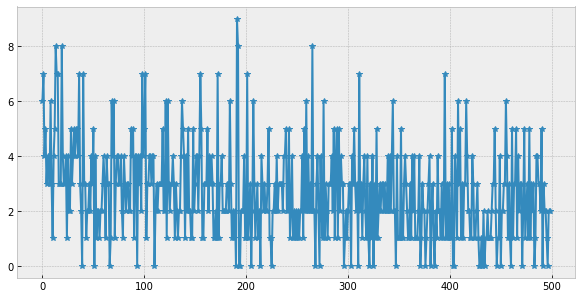

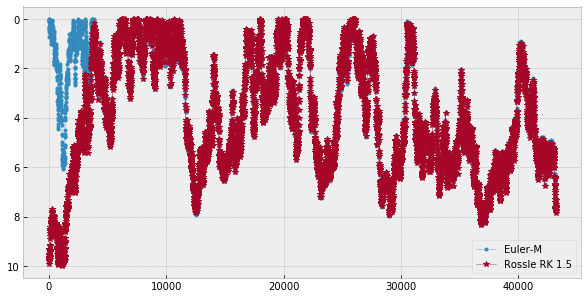

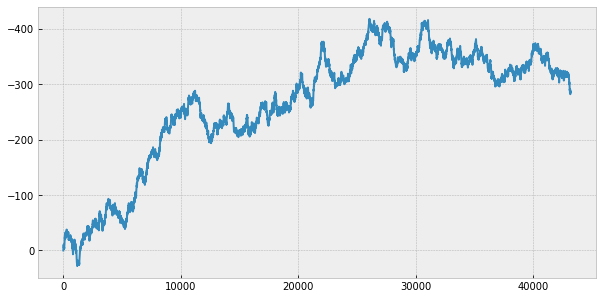

In [10]:

z0 = np.random.uniform(0, 10)
z0 = 9.9
hist, Z, T, W = simulation(z0 ,1, 500)
EulerZ = Euler_Maruyama(z0 ,T, W)

plt.figure(1, figsize = (10.0, 5.0))
plt.plot(hist, "-*")

plt.figure(2, figsize = (10.0, 5.0))
plt.plot(T, EulerZ, ".--", lw = 0.5, label = "Euler-M")
plt.plot(T, Z, "--*", lw = 0.5, label = "Rossle RK 1.5")
plt.legend()
plt.gca().invert_yaxis()

plt.figure(3, figsize = (10.0, 5.0))
plt.plot(T, W)
plt.gca().invert_yaxis()
plt.show()

#%%
#Error = 0
#Np = 1000
#for i in range(Np):
#    Z, T, W = simulation()
#    trueZ = True_solution(T, W)
#    temp = Z[-1] - trueZ[-1]
#    Error = temp*temp + Error
#Error = Error/Np
#print("Error: ", np.sqrt(Error))


In [6]:
print(hist)

[2 4 1 4 6 5 2 3 6 3 2 3 3 4 4 2 3 5 2 2 2 1 5 2 1 2 3 3 1 3 4 0 7 4 3 1 0
 4 3 2 1 1 2 1 0 2 0 0 5 1 1 1 4 1 1 4 1 3 1 2 3 2 2 1 1 0 5 3 0 3 2 1 2 1
 3 1 1 0 1 3 2 4 3 5 2 1 3 0 4 3 2 6 1 2 0 4 2 0 2 0 0 1 1 2 1 4 2 2 2 1 3
 1 2 0 0 0 2 1 3 0 2 1 0 0 1 1 2 0 0 1 1 1 0 1 1 3 1 2 2 3 3 3 1 0 0 0 0 3
 0 0 4 2 0 2 1 3 3 1 1 3 1 2 2 3 0 0 0 1 1 2 0 2 2 0 0 3 2 2 2 2 2 1 1 2 0
 1 1 1 2 2 1 2 0 3 1 1 0 0 2 1 1 4 0 2 3 2 2 0 0 0 0 0 2 1 2 1 0 1 2 0 3 2
 0 1 1 0 1 2 1 0 1 2 0 1 6 3 1 0 0 1 4 1 1 4 0 2 0 2 1 0 3 1 3 2 2 1 1 2 4
 0 1 4 0 1 1 1 2 1 2 2 0 0 3 1 0 2 1 1 1 2 0 1 1 3 1 0 1 0 1 1 1 2 2 3 0 2
 3 1 2 0 1 2 3 2 1 2 4 5 2 2 3 0 3 2 2 0 1 1 1 3 1 0 2 0 1 0 2 0 2 0 0 2 2
 2 2 0 1 1 2 5 1 3 4 4 1 2 2 2 1 3 1 2 0 1 2 5 0 2 1 0 0 0 1 1 0 3 5 0 2 1
 3 1 1 2 2 0 3 1 1 2 1 0 2 0 0 1 2 1 1 3 3 2 1 1 2 3 2 1 3 1 4 2 2 2 1 1 2
 3 3 2 0 3 2 0 1 5 2 0 4 1 1 0 1 5 0 2 2 1 1 1 2 0 1 2 2 0 2 2 2 4 0 1 1 0
 5 2 1 0 4 0 0 1 1 3 1 3 3 1 1 2 0 3 3 1 3 3 0 1 1 3 2 1 2 2 0 0 2 3 1 3 1
 3 3 1 1 6 1 2 0 0 1 2 1 